In [2]:
#Installing & Loading Packages
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import ranksums

/u/home/c/ctang04/.local/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Or, ignore specific categories of warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
# Load the patient methylation profiles
m_log1k_path = "/u/home/c/ctang04/HBV_Code/data/data.log1k.txt"
donors_path = "/u/home/c/ctang04/HBV_Code/data/donors.with.samples.txt"

In [5]:
# Read methylation profile
m_log1k_df = pd.read_csv(m_log1k_path, sep='\t', header=0, index_col=0)
#print(m_log1k_df.columns)

# Read donors file
donors_df = pd.read_csv(donors_path, sep='\t', header=0, quotechar='"')

# Remove duplicate samples by donor
unique_donors_df = donors_df.drop_duplicates(subset='donor')

# Get phase classes from the donors
phases = unique_donors_df['phase_HBV'].unique()
print(phases)

# Define mapping between original phases and desired classes
phase_mapping = {
    "Antiviral Rx": "Antiviral Rx",
    "IAH": "IAH",
    "IT": "IT",
    "RP": "RP",
    "RP and Cirrhosis": "Cirrhosis",
    "Antiviral Rx and Cirrh": "Cirrhosis",
    "SC": "SC",
    "ICP": "ICP",
    "IAH and Cirrhosis": "Cirrhosis",
    "SC and Cirrhosis": "Cirrhosis"
}

# Create a new column in the dataframe with the modified classes
unique_donors_df.loc[:, 'modified_phase'] = unique_donors_df['phase_HBV'].map(phase_mapping)

['Antiviral Rx' 'IAH' 'IT' 'RP' 'RP and Cirrhosis'
 'Antiviral Rx and Cirrh' 'SC' 'ICP' 'IAH and Cirrhosis'
 'SC and Cirrhosis']


In [6]:
class_mapping = {
    "IT": "IT",
    "IAH": "IAH",
    "Antiviral Rx": "Other",
    "ICP": "Other",
    "RP": "RP",
    "Cirrhosis": "Other"
}
unique_donors_df.loc[:, 'modified_class'] = unique_donors_df['modified_phase'].map(class_mapping)

In [7]:
# Subset unique_donors_df for the IT class (9)
IT_class_df = unique_donors_df[unique_donors_df['modified_class'] == "IT"]

# Extract sample names
IT_sample_names = IT_class_df['sample'].tolist()

# Subset m_log1k_df based on Active_sample_names
IT_class_data = m_log1k_df.loc[:, IT_sample_names]

print(IT_class_data.shape)   # Displaying the dimensions (rows, columns)

(144560, 9)


In [8]:
# Subset unique_donors_df for the IAH (67)
IAH_class_df = unique_donors_df[unique_donors_df['modified_class'] == "IAH"]

# Extract sample names
IAH_sample_names = IAH_class_df['sample'].tolist()

# Subset m_log1k_df based on Active_sample_names
IAH_class_data = m_log1k_df.loc[:, IAH_sample_names]

print(IAH_class_data.shape)   # Displaying the dimensions (rows, columns)

(144560, 67)


In [9]:
# Subset unique_donors_df for the RP (33)
RP_class_df = unique_donors_df[unique_donors_df['modified_class'] == "RP"]

# Extract sample names
RP_sample_names = RP_class_df['sample'].tolist()

# Subset m_log1k_df based on Active_sample_names
RP_class_data = m_log1k_df.loc[:, RP_sample_names]

print(RP_class_data.shape)   # Displaying the dimensions (rows, columns)

(144560, 33)


In [10]:
# Transpose the DataFrames so that sample names are rows and methylation sites are columns
IT_class_data_t = IT_class_data.T
IAH_class_data_t = IAH_class_data.T
RP_class_data_t = RP_class_data.T

# Add a label column to each transposed DataFrame
IT_class_data_t['label'] = 0  # Label for IT
IAH_class_data_t['label'] = 1  # Label for IAH
RP_class_data_t['label'] = 2  # Label for RP

# Concatenate the transposed DataFrames along the rows (axis=0)
combined_df = pd.concat([IT_class_data_t, IAH_class_data_t, RP_class_data_t])

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Print shapes to verify dimensions
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y)

X_train shape: (87, 144560)
X_test shape: (22, 144560)
y_train shape: (87,)
y_test shape: (22,)
plasma-646-P9-CH             0
plasma-649-t8-6day-P9-CH     0
plasma-1626-P9-CH            0
plasma-3869-P9-CH            0
plasma-2457-P9-CH            0
                            ..
plasma-3409-P9-CH            2
plasma-2502-P9-CH            2
plasma-2738-P9-CH            2
plasma-2577-5day-P9-CH       2
plasma-2568-r1-4day-P9-CH    2
Name: label, Length: 109, dtype: int64


In [12]:
# Separate the active and inactive groups in the training data
X_train_IT = X_train[y_train == 0]
X_train_IAH = X_train[y_train == 1]
X_train_RP = X_train[y_train == 2]

print(X_train_IT.shape)
print(X_train_IAH.shape)
print(X_train_RP.shape)

(7, 144560)
(54, 144560)
(26, 144560)


In [12]:
#methylation_sites = X_train.columns
#print(methylation_sites.shape)
#print(X_train_active.shape)
#print(X_train_inactive.shape)

# P value only

In [13]:
#X_train_IT 
#X_train_IAH 
#X_train_RP 
p_values_ITvRest = []
X_train_active_IT = X_train_IT
X_train_inactive_Rest = pd.concat([X_train_IAH,X_train_RP])

methylation_sites = X_train.columns

for site in methylation_sites:
    active_values = X_train_active_IT[site].values
    inactive_values = X_train_inactive_Rest[site].values
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)  # Wilcoxon rank-sum test
    p_values_ITvRest.append(p_val)
#print(len(p_values_ITvRest))

# Create a DataFrame for the results
results_df_ITvRest = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_ITvRest
})

significant_sites05_ITvRest = results_df_ITvRest[results_df_ITvRest['p_value'] < 0.05]
significant_sites05_ITvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRest_p05_ttest.csv', index=False)
significant_sites01_ITvRest = results_df_ITvRest[results_df_ITvRest['p_value'] < 0.01]
significant_sites01_ITvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRest_p01_ttest.csv', index=False)
# Print the significant sites
print(significant_sites05_ITvRest.shape)
print(significant_sites01_ITvRest.shape)

(16305, 2)
(8535, 2)


In [14]:
p_values_IAHvRest = []
X_train_active_IAH = X_train_IAH
X_train_inactive_Rest = pd.concat([X_train_IT,X_train_RP])

methylation_sites = X_train.columns

for site in methylation_sites:
    active_values = X_train_active_IAH[site].values
    inactive_values = X_train_inactive_Rest[site].values
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)  # Wilcoxon rank-sum test
    p_values_IAHvRest.append(p_val)
#print(len(p_values_ITvRest))

# Create a DataFrame for the results
results_df_IAHvRest = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_IAHvRest
})

significant_sites05_IAHvRest = results_df_IAHvRest[results_df_IAHvRest['p_value'] < 0.05]
significant_sites05_IAHvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/IAHvRest_p05_ttest.csv', index=False)
significant_sites01_IAHvRest = results_df_IAHvRest[results_df_IAHvRest['p_value'] < 0.01]
significant_sites01_IAHvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/IAHvRest_p01_ttest.csv', index=False)
# Print the significant sites
print(significant_sites05_IAHvRest.shape)
print(significant_sites01_IAHvRest.shape)

(5841, 2)
(1001, 2)


In [15]:
p_values_RPvRest = []
X_train_active_RP = X_train_RP
X_train_inactive_Rest = pd.concat([X_train_IT,X_train_IAH])

methylation_sites = X_train.columns

for site in methylation_sites:
    active_values = X_train_active_RP[site].values
    inactive_values = X_train_inactive_Rest[site].values
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)  # Wilcoxon rank-sum test
    p_values_RPvRest.append(p_val)
#print(len(p_values_ITvRest))

# Create a DataFrame for the results
results_df_IAHvRest = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_RPvRest
})

significant_sites05_RPvRest = results_df_IAHvRest[results_df_IAHvRest['p_value'] < 0.05]
significant_sites05_RPvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/IAHvRest_p05_ttest.csv', index=False)
significant_sites01_RPvRest = results_df_IAHvRest[results_df_IAHvRest['p_value'] < 0.01]
significant_sites01_RPvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/IAHvRest_p01_ttest.csv', index=False)
# Print the significant sites
print(significant_sites05_RPvRest.shape)
print(significant_sites01_RPvRest.shape)

(4756, 2)
(805, 2)


# P value and Fold Change

In [13]:
X_train_active_IT = X_train_IT
X_train_inactive_Rest = pd.concat([X_train_IAH, X_train_RP])

methylation_sites = X_train.columns

p_values_ITvRest = []
fold_changes_ITvRest = []

for site in methylation_sites:
    active_values = X_train_active_IT[site].values
    inactive_values = X_train_inactive_Rest[site].values

    # Perform Welch's t-test
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)
    p_values_ITvRest.append(p_val)

    # Calculate fold change with pseudocount
    pseudocount = 0.001
    mean_active = np.mean(active_values)
    mean_inactive = np.mean(inactive_values)
    
    if mean_inactive != 0:
        fold_change = np.log2((mean_active + pseudocount) / (mean_inactive + pseudocount))
    else:
        fold_change = float('NaN')  # Handle division by zero case

    fold_changes_ITvRest.append(fold_change)

# Create a DataFrame for the results
results_df_ITvRest = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_ITvRest,
    'fold_change': fold_changes_ITvRest
})

# Filter significant sites based on p-value thresholds
significant_sites05_ITvRest = results_df_ITvRest[results_df_ITvRest['p_value'] < 0.05]
significant_sites05_ITvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRest_p05_ttest_fold_change.csv', index=False)
significant_sites01_ITvRest = results_df_ITvRest[results_df_ITvRest['p_value'] < 0.01]
significant_sites01_ITvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/ITvRest_p01_ttest_fold_change.csv', index=False)

# Print the number of significant sites
print(significant_sites05_ITvRest.shape)
print(significant_sites01_ITvRest.shape)

(16305, 3)
(8535, 3)


In [14]:
X_train_active_IAH = X_train_IAH
X_train_inactive_Rest = pd.concat([X_train_IT, X_train_RP])

methylation_sites = X_train.columns

p_values_IAHvRest = []
fold_changes_IAHvRest = []

for site in methylation_sites:
    active_values = X_train_active_IAH[site].values
    inactive_values = X_train_inactive_Rest[site].values

    # Perform Welch's t-test
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)
    p_values_IAHvRest.append(p_val)

    # Calculate fold change with pseudocount
    pseudocount = 0.001
    mean_active = np.mean(active_values)
    mean_inactive = np.mean(inactive_values)
    
    if mean_inactive != 0:
        fold_change = np.log2((mean_active + pseudocount) / (mean_inactive + pseudocount))
    else:
        fold_change = float('NaN')  # Handle division by zero case

    fold_changes_IAHvRest.append(fold_change)

# Create a DataFrame for the results
results_df_IAHvRest = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_IAHvRest,
    'fold_change': fold_changes_IAHvRest
})

# Filter significant sites based on p-value thresholds
significant_sites05_IAHvRest = results_df_IAHvRest[results_df_IAHvRest['p_value'] < 0.05]
significant_sites05_IAHvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/IAHvRest_p05_ttest_fold_change.csv', index=False)
significant_sites01_IAHvRest = results_df_IAHvRest[results_df_IAHvRest['p_value'] < 0.01]
significant_sites01_IAHvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/IAHvRest_p01_ttest_fold_change.csv', index=False)

# Print the number of significant sites
print(significant_sites05_IAHvRest.shape)
print(significant_sites01_IAHvRest.shape)

(5841, 3)
(1001, 3)


In [15]:
X_train_active_RP = X_train_RP
X_train_inactive_Rest = pd.concat([X_train_IT, X_train_IAH])

methylation_sites = X_train.columns

p_values_RPvRest = []
fold_changes_RPvRest = []

for site in methylation_sites:
    active_values = X_train_active_RP[site].values
    inactive_values = X_train_inactive_Rest[site].values

    # Perform Welch's t-test
    t_stat, p_val = ttest_ind(active_values, inactive_values, equal_var=False)
    p_values_RPvRest.append(p_val)

    # Calculate fold change with pseudocount
    pseudocount = 0.001
    mean_active = np.mean(active_values)
    mean_inactive = np.mean(inactive_values)
    
    if mean_inactive != 0:
        fold_change = np.log2((mean_active + pseudocount) / (mean_inactive + pseudocount))
    else:
        fold_change = float('NaN')  # Handle division by zero case

    fold_changes_RPvRest.append(fold_change)

# Create a DataFrame for the results
results_df_RPvRest = pd.DataFrame({
    'methylation_site': methylation_sites,
    'p_value': p_values_RPvRest,
    'fold_change': fold_changes_RPvRest
})

# Filter significant sites based on p-value thresholds
significant_sites05_RPvRest = results_df_RPvRest[results_df_RPvRest['p_value'] < 0.05]
significant_sites05_RPvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/RPvRest_p05_ttest_fold_change.csv', index=False)
significant_sites01_RPvRest = results_df_RPvRest[results_df_RPvRest['p_value'] < 0.01]
significant_sites01_RPvRest.to_csv('/u/home/c/ctang04/HBV_Code/output/RPvRest_p01_ttest_fold_change.csv', index=False)

# Print the number of significant sites
print(significant_sites05_RPvRest.shape)
print(significant_sites01_RPvRest.shape)

(4756, 3)
(805, 3)


# Union

In [17]:
union_significant_sites05_1vRest = pd.concat([significant_sites05_ITvRest,significant_sites05_IAHvRest,significant_sites05_RPvRest])
union_significant_sites05_1vRest.drop_duplicates().reset_index(drop=True)
print(union_significant_sites05_1vRest)

union_significant_sites01_1vRest = pd.concat([significant_sites01_ITvRest,significant_sites01_IAHvRest,significant_sites01_RPvRest])
union_significant_sites01_1vRest.drop_duplicates().reset_index(drop=True)
print(union_significant_sites01_1vRest)

                 methylation_site   p_value  fold_change
0       chr10_100027865_100027984  0.016989    -7.359707
13      chr10_100227770_100227889  0.013054    -7.381978
16      chr10_100992139_100992258  0.000111    -8.487823
17      chr10_100992275_100992394  0.000456    -8.335992
18      chr10_100992374_100992493  0.000488    -8.237551
...                           ...       ...          ...
121894     chr7_29846363_29846482  0.047709    -6.804783
122202     chr7_79764580_79764699  0.029163    -7.392649
122693   chr8_145911314_145911433  0.047533          NaN
122720     chr8_17658570_17658689  0.024195          NaN
123445   chr9_132199788_132199907  0.046934          NaN

[26902 rows x 3 columns]
                 methylation_site   p_value  fold_change
16      chr10_100992139_100992258  0.000111    -8.487823
17      chr10_100992275_100992394  0.000456    -8.335992
18      chr10_100992374_100992493  0.000488    -8.237551
23      chr10_100993566_100993685  0.002660    -7.949635
36   

In [18]:
fold_change_threshold = 2
significant_sites_05_fold_change = union_significant_sites05_1vRest[union_significant_sites05_1vRest['fold_change'] > fold_change_threshold]
print(significant_sites_05_fold_change)

significant_sites_05 = significant_sites_05_fold_change['methylation_site'].tolist()

# Select significant features from the training and testing data
X_train_significant = X_train[significant_sites_05]
X_test_significant = X_test[significant_sites_05]


print(X_train_significant.shape)
print(X_test_significant.shape)
print(y_train.shape)
print(y_test.shape)


                 methylation_site   p_value  fold_change
9689      chr11_69634629_69634748  0.016766     2.779214
10941   chr12_108238515_108238634  0.003203     2.437523
11385   chr12_114877345_114877464  0.003504     2.344901
15769   chr13_109148900_109149019  0.024788     2.195102
15983   chr13_112758417_112758536  0.023857     2.442189
...                           ...       ...          ...
116112   chr2_219867615_219867734  0.036380     3.857768
118249     chr3_98451598_98451717  0.017288     4.394382
118250     chr3_98451691_98451810  0.006955     3.805465
119636     chr5_31855140_31855259  0.002300     4.846784
121515   chr7_132260465_132260584  0.021858     2.702360

[923 rows x 3 columns]
(87, 923)
(22, 923)
(87,)
(22,)


In [19]:
#print(X_train_significant)
print(X_train_significant.shape)  # Should be (n_samples, n_features)
print(X_test_significant.shape)   # Should be (n_samples, n_features)
print(y_train.shape)              # Should be (n_samples,)
print(y_test.shape)               # Should be (n_samples,)

#X_train_sig_vals = X_train_significant.values
np_X_train_significant = X_train_significant.to_numpy()
np_X_test_significant = X_test_significant.to_numpy()
np_y_train = y_train.to_numpy()
np_y_test = y_test.to_numpy()

print(np_X_train_significant)
#print("Columns in X_train_significant:", X_train_significant.columns)
#print("Columns in X_test_significant:", X_test_significant.columns)

(87, 923)
(22, 923)
(87,)
(22,)
[[0.         1.58261415 0.         ... 0.         0.         0.        ]
 [0.         0.         1.64118352 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [2.52298426 1.57317096 0.         ... 0.         0.         0.        ]]


In [30]:
dtrain = xgb.DMatrix(np_X_train_significant, label=y_train)
dtest = xgb.DMatrix(np_X_test_significant, label=y_test)

In [32]:
#param = {'objective': 'multi:softmax', 'num_class': 3} #, 'max_depth' : 4, 'lambda':0.4, 'eta' : 0.1
param = {'objective': 'multi:softmax', 'num_class': 3, 'max_depth' : 4, 'lambda':3, 'eta' : 0.3}
param['eval_metric'] = ['auc', 'mlogloss', 'merror'] #merror

#dictionary to store evaluation results
evals_result = {}
# Evaluation list
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Number of boosting rounds
num_round = 20

# Training the model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10,evals_result=evals_result)

[0]	train-auc:0.98990	train-mlogloss:0.82404	train-merror:0.03448	eval-auc:0.56995	eval-mlogloss:1.00795	eval-merror:0.45455
[1]	train-auc:1.00000	train-mlogloss:0.63707	train-merror:0.03448	eval-auc:0.58548	eval-mlogloss:0.94411	eval-merror:0.45455
[2]	train-auc:1.00000	train-mlogloss:0.50925	train-merror:0.02299	eval-auc:0.57879	eval-mlogloss:0.92610	eval-merror:0.45455
[3]	train-auc:1.00000	train-mlogloss:0.40965	train-merror:0.01149	eval-auc:0.62727	eval-mlogloss:0.93303	eval-merror:0.45455
[4]	train-auc:1.00000	train-mlogloss:0.33425	train-merror:0.00000	eval-auc:0.57828	eval-mlogloss:0.95335	eval-merror:0.45455
[5]	train-auc:1.00000	train-mlogloss:0.27574	train-merror:0.00000	eval-auc:0.59293	eval-mlogloss:0.95809	eval-merror:0.40909
[6]	train-auc:1.00000	train-mlogloss:0.23150	train-merror:0.00000	eval-auc:0.61717	eval-mlogloss:0.97878	eval-merror:0.40909
[7]	train-auc:1.00000	train-mlogloss:0.19892	train-merror:0.00000	eval-auc:0.62399	eval-mlogloss:0.97644	eval-merror:0.40909


In [33]:
# Extract the metrics history
train_auc = evals_result['train']['auc']
eval_auc = evals_result['eval']['auc']
train_mlogloss = evals_result['train']['mlogloss']
eval_mlogloss = evals_result['eval']['mlogloss']
train_merror = evals_result['train']['merror']
eval_merror = evals_result['eval']['merror']

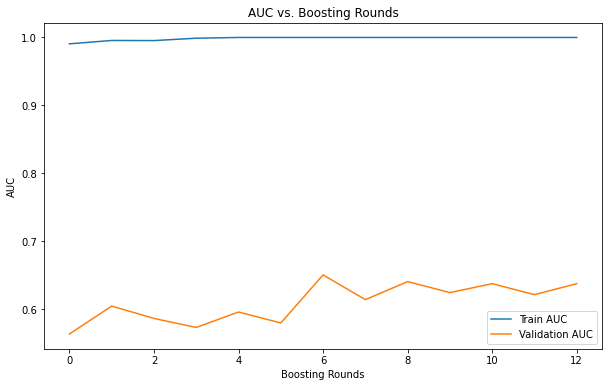

In [23]:
# Plot the AUC
plt.figure(figsize=(10, 6))
plt.plot(train_auc, label='Train AUC')
plt.plot(eval_auc, label='Validation AUC')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.title('AUC vs. Boosting Rounds')
plt.legend()
plt.show()

In [24]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42)
model.fit(np_X_train_significant, y_train)
y_pred = model.predict(np_X_test_significant)
# Predict the probabilities for the test set
#y_pred_proba = model.predict_proba(X_test_significant)[:, 1]

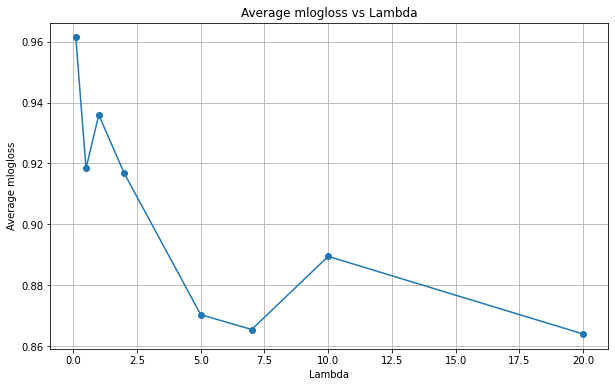

Lambda: 0.1, Average mlogloss: 0.9613731354572413
Lambda: 0.5, Average mlogloss: 0.918356503525542
Lambda: 1.0, Average mlogloss: 0.9359567663930599
Lambda: 2.0, Average mlogloss: 0.9167710732595594
Lambda: 5.0, Average mlogloss: 0.8703395184726009
Lambda: 7, Average mlogloss: 0.8654665545992601
Lambda: 10, Average mlogloss: 0.8894852171037224
Lambda: 20, Average mlogloss: 0.8639985749461486


In [25]:
# Set fixed parameters
fixed_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eta': 1,
    'max_depth': 4,
    'alpha':  1,
    'eval_metric': 'mlogloss'
}

# Define range of lambda values to test
lambda_values = [0.1, 0.5, 1.0, 2.0, 5.0, 7,10, 20]

# Store average mlogloss for each lambda value
average_mlogloss = []

# Perform cross-validation for each lambda value
for lam in lambda_values:
    params = fixed_params.copy()
    params['lambda'] = lam
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        nfold=5,  # Number of cross-validation folds
        early_stopping_rounds=10,
        seed=42
    )
    
    # Get the mean mlogloss from the cross-validation results
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    average_mlogloss.append(mean_mlogloss)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, average_mlogloss, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average mlogloss')
plt.title('Average mlogloss vs Lambda')
plt.grid(True)
plt.show()

# Print the results
for lam, mlogloss in zip(lambda_values, average_mlogloss):
    print(f"Lambda: {lam}, Average mlogloss: {mlogloss}")

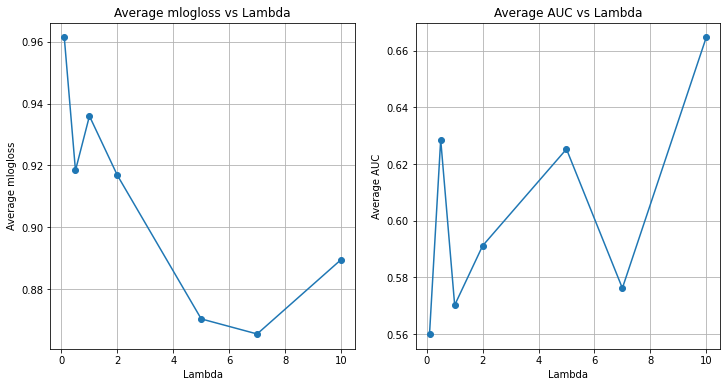

Lambda: 0.1, Average mlogloss: 0.9613731354572413, Average AUC: 0.5600732600732602
Lambda: 0.5, Average mlogloss: 0.918356503525542, Average AUC: 0.6285714285714286
Lambda: 1.0, Average mlogloss: 0.9359567663930599, Average AUC: 0.5702380952380953
Lambda: 2.0, Average mlogloss: 0.9167710732595594, Average AUC: 0.5911680911680912
Lambda: 5.0, Average mlogloss: 0.8703395184726009, Average AUC: 0.6252543752543753
Lambda: 7.0, Average mlogloss: 0.8654665545992601, Average AUC: 0.5762311762311761
Lambda: 10, Average mlogloss: 0.8894852171037224, Average AUC: 0.6646113146113146


In [27]:
from sklearn.preprocessing import label_binarize
# Binarize the labels for AUC calculation
y_bin_test = label_binarize(y_test, classes=[0, 1, 2])
# Set fixed parameters
fixed_params = {
    'objective': 'multi:softprob',  # Change to 'multi:softprob' for probability outputs
    'num_class': 3,
    'eta': 1,
    'max_depth': 4,
    'alpha': 1,
    'eval_metric': 'mlogloss'  # Using mlogloss as the evaluation metric
}

# Define range of lambda values to test
lambda_values = [0.1, 0.5, 1.0, 2.0, 5.0,7.0, 10]

# Store average mlogloss and AUC for each lambda value
average_mlogloss = []
average_auc = []

# Perform cross-validation for each lambda value
for lam in lambda_values:
    params = fixed_params.copy()
    params['lambda'] = lam
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        nfold=5,  # Number of cross-validation folds
        early_stopping_rounds=10,
        seed=42
    )
    
    # Get the mean mlogloss from the cross-validation results
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    average_mlogloss.append(mean_mlogloss)
    
    # Train the model and compute AUC on the test set
    model = xgb.train(params, dtrain, num_boost_round=len(cv_results))
    y_pred_proba = model.predict(dtest)
    auc = roc_auc_score(y_bin_test, y_pred_proba, multi_class='ovr')
    average_auc.append(auc)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lambda_values, average_mlogloss, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average mlogloss')
plt.title('Average mlogloss vs Lambda')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambda_values, average_auc, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average AUC')
plt.title('Average AUC vs Lambda')
plt.grid(True)

plt.show()

# Print the results
for lam, mlogloss, auc in zip(lambda_values, average_mlogloss, average_auc):
    print(f"Lambda: {lam}, Average mlogloss: {mlogloss}, Average AUC: {auc}")

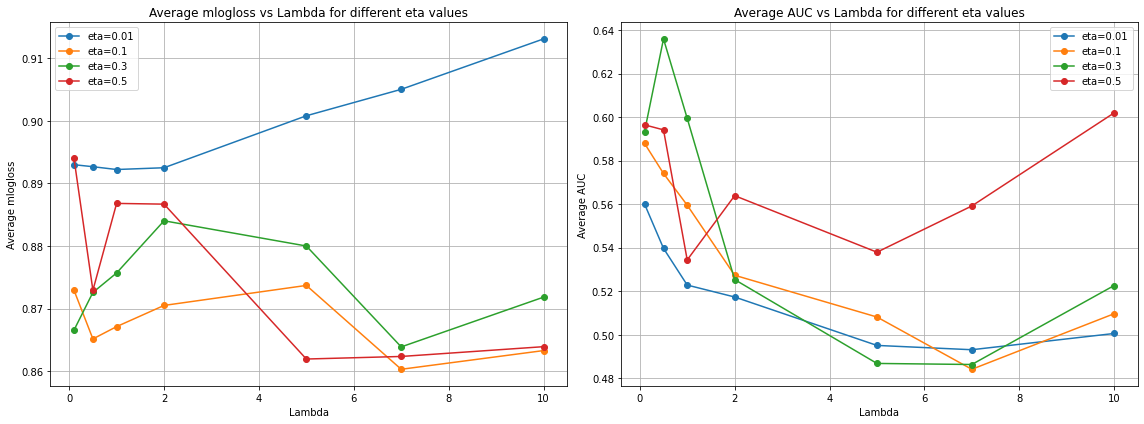

Lambda: 0.1, eta: 0.01, Average mlogloss: 0.8929959827194025, Average AUC: 0.5600732600732602
Lambda: 0.1, eta: 0.1, Average mlogloss: 0.8729494200812447, Average AUC: 0.5879222629222629
Lambda: 0.1, eta: 0.3, Average mlogloss: 0.8665289506705758, Average AUC: 0.5933150183150183
Lambda: 0.1, eta: 0.5, Average mlogloss: 0.8940670748551686, Average AUC: 0.5964590964590964
Lambda: 0.5, eta: 0.01, Average mlogloss: 0.8926742966268577, Average AUC: 0.5396927146927146
Lambda: 0.5, eta: 0.1, Average mlogloss: 0.8651418047208412, Average AUC: 0.5741045991045991
Lambda: 0.5, eta: 0.3, Average mlogloss: 0.8725726803533391, Average AUC: 0.635948310948311
Lambda: 0.5, eta: 0.5, Average mlogloss: 0.8729175159062436, Average AUC: 0.5941493691493692
Lambda: 1.0, eta: 0.01, Average mlogloss: 0.8922251971523746, Average AUC: 0.5228123728123728
Lambda: 1.0, eta: 0.1, Average mlogloss: 0.8671110039442972, Average AUC: 0.5595339845339845
Lambda: 1.0, eta: 0.3, Average mlogloss: 0.8756890296838641, Average

In [28]:
# Binarize the test labels for AUC calculation
y_bin_test = label_binarize(y_test, classes=[0, 1, 2])

# Set fixed parameters
fixed_params = {
    'objective': 'multi:softprob',  # Change to 'multi:softprob' for probability outputs
    'num_class': 3,
    'max_depth': 4,
    'alpha': 1,
    'eval_metric': 'mlogloss'  # Using mlogloss as the evaluation metric
}

# Define range of lambda and eta values to test
lambda_values = [0.1, 0.5, 1.0, 2.0, 5.0, 7.0, 10.0]
eta_values = [0.01, 0.1, 0.3, 0.5]

# Store average mlogloss and AUC for each lambda and eta value
results = []

# Perform grid search for each lambda and eta combination
for lam in lambda_values:
    for eta in eta_values:
        params = fixed_params.copy()
        params['lambda'] = lam
        params['eta'] = eta

        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=100,
            nfold=5,  # Number of cross-validation folds
            early_stopping_rounds=10,
            seed=42
        )

        # Get the mean mlogloss from the cross-validation results
        mean_mlogloss = cv_results['test-mlogloss-mean'].min()

        # Train the model and compute AUC on the test set
        model = xgb.train(params, dtrain, num_boost_round=len(cv_results))
        y_pred_proba = model.predict(dtest)
        auc = roc_auc_score(y_bin_test, y_pred_proba, multi_class='ovr')

        # Store results
        results.append({
            'lambda': lam,
            'eta': eta,
            'average_mlogloss': mean_mlogloss,
            'average_auc': auc
        })

# Extract results for plotting
lambda_eta_pairs = [(res['lambda'], res['eta']) for res in results]
average_mlogloss = [res['average_mlogloss'] for res in results]
average_auc = [res['average_auc'] for res in results]

# Plot the results
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for eta in eta_values:
    plt.plot(lambda_values, [res['average_mlogloss'] for res in results if res['eta'] == eta], marker='o', label=f'eta={eta}')
plt.xlabel('Lambda')
plt.ylabel('Average mlogloss')
plt.title('Average mlogloss vs Lambda for different eta values')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for eta in eta_values:
    plt.plot(lambda_values, [res['average_auc'] for res in results if res['eta'] == eta], marker='o', label=f'eta={eta}')
plt.xlabel('Lambda')
plt.ylabel('Average AUC')
plt.title('Average AUC vs Lambda for different eta values')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the results
for res in results:
    print(f"Lambda: {res['lambda']}, eta: {res['eta']}, Average mlogloss: {res['average_mlogloss']}, Average AUC: {res['average_auc']}")

In [34]:
y_pred = model.predict(np_X_test_significant)
y_pred_proba = model.predict_proba(np_X_test_significant)
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC Score: {roc_auc:.2f}')

AttributeError: 'Booster' object has no attribute 'predict_proba'

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate sensitivity (recall) for each class
sensitivity = np.diag(cm) / np.sum(cm, axis=1)

# Calculate specificity for each class
specificity = []
for i in range(cm.shape[0]):
    # True negatives (TN) for class i
    TN = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    # False positives (FP) and true negatives (TN) for class i
    FP_plus_TN = np.sum(cm) - np.sum(cm[:, i])
    # Specificity for class i
    if FP_plus_TN == 0:
        specificity_i = 0
    else:
        specificity_i = TN / FP_plus_TN
    specificity.append(specificity_i)

# Print results for sensitivity and specificity
for i in range(cm.shape[0]):
    print(f'Class {i}: Sensitivity (Recall) = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}')

In [43]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42, max_depth= 5, reg_lambda = 0.5, eta = 0.3)
model.fit(np_X_train_significant, y_train)
y_pred = model.predict(np_X_test_significant)
y_pred_proba = model.predict_proba(np_X_test_significant)
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC Score: {roc_auc:.2f}')

Accuracy: 0.64
ROC AUC Score: 0.60


In [45]:
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42, max_depth= 5, reg_lambda = 0.5, eta = 0.3)
model.fit(np_X_train_significant, y_train)
y_pred = model.predict(np_X_test_significant)
y_pred_proba = model.predict_proba(np_X_test_significant)
#Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate ROC AUC score for each class
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate sensitivity (recall) for each class
sensitivity = np.diag(cm) / np.sum(cm, axis=1)

# Calculate specificity for each class
specificity = []
for i in range(cm.shape[0]):
    # True negatives (TN) for class i
    TN = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    # False positives (FP) and true negatives (TN) for class i
    FP_plus_TN = np.sum(cm) - np.sum(cm[:, i])
    # Specificity for class i
    if FP_plus_TN == 0:
        specificity_i = 0
    else:
        specificity_i = TN / FP_plus_TN
    specificity.append(specificity_i)

# Print results for sensitivity and specificity
for i in range(cm.shape[0]):
    print(f'Class {i}: Sensitivity (Recall) = {sensitivity[i]:.2f}, Specificity = {specificity[i]:.2f}')

Accuracy: 0.64
ROC AUC Score: 0.60
[[ 0  2  0]
 [ 0 11  2]
 [ 0  4  3]]
Class 0: Sensitivity (Recall) = 0.00, Specificity = 0.91
Class 1: Sensitivity (Recall) = 0.85, Specificity = 0.60
Class 2: Sensitivity (Recall) = 0.43, Specificity = 0.76
